<a href="https://colab.research.google.com/github/slayAlphalu/slayAlphalu.github.io/blob/master/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A2: Image classification in the brower

In this assignment, you will gain real-world experience with image classification on small datasets - a common scenario in practice. There are three parts.

1. First, you will train a model on a small existing dataset.

2. Next,  you will collect a small dataset yourself. Of course, in practice there isn’t often a dataset available for tasks you care about, so it’s valuable to get a feel for this process. You will train a small model from scratch, then use data augmentation to improve accuracy.

3. Finally, you will deploy your model from part two in a webpage using TensorFlow.js. A user will be able to upload a photo, and your model will classify it.

## Instructions

Please complete this notebook by searching for **"TODO"**.

## Submission instructions

Please submit this assignment on CourseWorks by uploading a Jupyter notebook that includes saved output. If you are working in Colab, you can prepare your notebook for submission by ensuring that runs end-to-end, then saving and downloading it:

1. ```Runtime -> Restart and run all```
1. ```File -> Save```
1. ```File -> Download.ipynb```

Note: you will need to include a URL to your webpage for part 3, see the final TODO at the bottom of this notebook.

## Setup instructions
1. If you are running this notebook in Colab, make sure a GPU is enabled (```Edit -> Notebook settings -> Hardware accelerator```).

2. Create a GitHub Pages repo by following the instructions at https://pages.github.com/. You may use this to host your webpage.

In [0]:
try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc2


## 1a) Flowers

In this part of the assignment, you will train a model on a small existing dataset (flowers).

In [0]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time

from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 192
SHUFFLE_SIZE = 1000

### Download the flowers dataset

In [0]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

/root/.keras/datasets/flower_photos


### Write an input pipeline from scratch
There are several ways to load images in TensorFlow. Later in this assignment, you'll use the [Keras preprocessing utilities](https://keras.io/preprocessing/image/). For starters, though, you'll write your own using ```tf.data```, based on this [tutorial](https://www.tensorflow.org/beta/tutorials/load_data/images). This is valuable to do once (just so you can see how the nuts and bolts work) before using the higher level utils. A bunch of the code is written for you, there are only a couple of TODOs. Follow along, though, and try to understand each piece.


In [0]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [0]:
all_image_paths[:5]

['/root/.keras/datasets/flower_photos/roses/15424480096_45bb574b33.jpg',
 '/root/.keras/datasets/flower_photos/tulips/16951623209_00fb7ec1b1_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/2634666217_d5ef87c9f7_m.jpg',
 '/root/.keras/datasets/flower_photos/daisy/4117918318_3c8935289b_m.jpg',
 '/root/.keras/datasets/flower_photos/roses/22325299158_6e32e599f8_m.jpg']

### Get to know your data

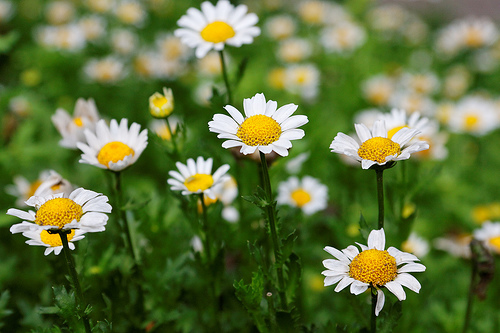

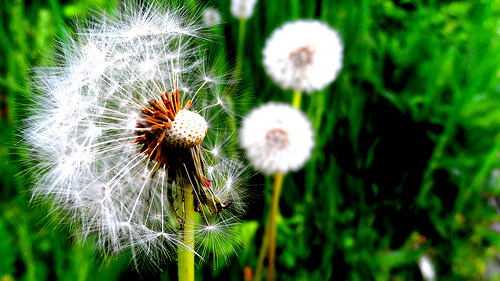

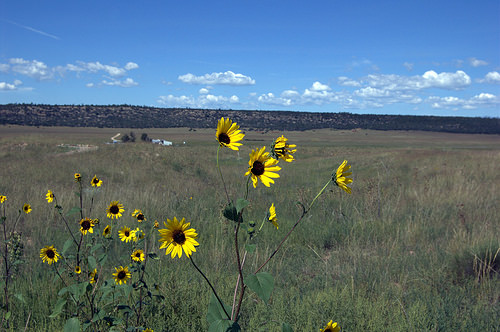

In [0]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print()

### Classes are given by directory names

In [0]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [0]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [0]:
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_labels[:10])

First 10 labels indices:  [2, 4, 1, 0, 2, 1, 0, 1, 1, 1]


### Create a train/test split

In [0]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels)   

### Display a few images and their labels

dandelion


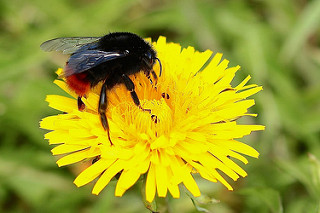


tulips


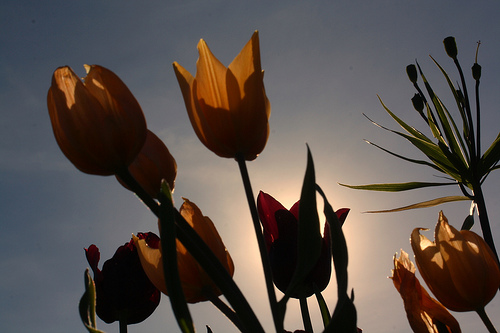


tulips


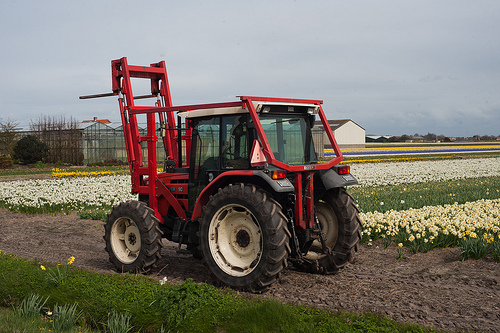

In [0]:
for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(label_names[train_labels[i]])
  display.display(display.Image(image_path))
  print()

### Begin using TensorFlow ops to read and decode the images

In [0]:
img_raw = tf.io.read_file(train_paths[0])
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


In [0]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(240, 159, 3)
<dtype: 'uint8'>


In [0]:
img_final = tf.image.resize(img_tensor, [IMG_SIZE, IMG_SIZE])
img_final = img_final / 255.0 # normalize pixel values
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
0.99971277


### Wrap those in a function
Tip: pay careful attention to the preprocessing. When you deploy models in the browser, you will need to ensure that images are preprocessed identically in JavaScript as they are in Python.

In [0]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize to [0,1] range
  return img

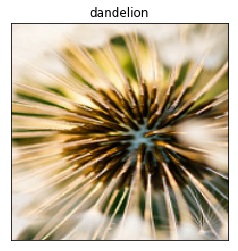

In [0]:
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

img_path = train_paths[0]
img = load_and_preprocess_image(img_path)
label = label_names[train_labels[0]]
show(img, label)

### Build an input pipeline to return images and labels
I realize this is complicated. The problem we're trying to solve using tf.data is performance (we want our preprocessing to run in C, but to write our code in Python). There are a bunch of advanced tricks you can do with tf.data as well (e.g. prefetching images to the GPU).

Note: although your *peak* performance can be higher, it's also very easy to make mistakes and end up with code that's super slow. Always benchmark your input pipelines before using them (shown in a bit). 

In [0]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
for n, img_path in enumerate(path_ds.take(4)):
  print(n, img_path)

0 tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/19443726008_8c9c68efa7_m.jpg', shape=(), dtype=string)
1 tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/54377391_15648e8d18.jpg', shape=(), dtype=string)
2 tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/4568317687_3f89622f76.jpg', shape=(), dtype=string)
3 tf.Tensor(b'/root/.keras/datasets/flower_photos/roses/3103591125_99107c8bbe_n.jpg', shape=(), dtype=string)


In [0]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(image_ds.take(4)):
  print(n, image.shape)

0 (192, 192, 3)
1 (192, 192, 3)
2 (192, 192, 3)
3 (192, 192, 3)


In [0]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(4):
  print(label_names[label.numpy()])

dandelion
daisy
dandelion
roses


In [0]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [0]:
for img, label in image_label_ds.take(2):
  print(img.shape, label_names[label.numpy()])

(192, 192, 3) dandelion
(192, 192, 3) daisy


### Batch and shuffle
Why do we need to specify a shuffle_size parameter? tf.data works with streams (it doesn't know their length). To shuffle items, we maintain an in-memory buffer of this size.

In [0]:
ds = image_label_ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(32, 192, 192, 3) (32,)
(32, 192, 192, 3) (32,)


At this point, you could use the dataset above to train a model with ```model.fit(ds)``` but first, let's improve performance. As written, the dataset will load each image off disk, one at a time (super slow). Instead, we want to cache them in memory.

### Improve performance

In [0]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

### Use in-memory caching
This is a small dataset, so let's keep it in memory. The first time we iterate over this dataset, images will be loaded off disk, then cached. The first iteration will be quite slow, and subsequent ones will be faster. Let's show that. 

In [0]:
ds = image_label_ds.cache() # cache data in mempry
ds = ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [0]:
time_one_epoch(ds) # this will be slow

.........
Read 86 batches
14.79 Batches/s
473.24 Images/s
Total time: 5.8151772022247314s


Now that the cache is built, iteration will be much faster.

In [0]:
time_one_epoch(ds) # this will be fast

.........
Read 86 batches
193.95 Batches/s
6206.53 Images/s
Total time: 0.4434037208557129s


If the dataset did not fit into memory, you could use a cache file on disk, like this:

```
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.shuffle(buffer_size=BUFFER_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
```

This can be useful to perform expensive preprocessing only once, and/or to improve file I/O (TF saves the cache file in an efficient format - it can be faster to read one large file than a bunch of small ones).

In [0]:
# here's our final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# let's make a test dataset as well
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds.cache().batch(BATCH_SIZE)

### Finally, we have a fast pipeline ready to go, written from scratch
Now, let's define a model.

## 1b) Create a simple CNN

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

### TODO: your code here
# Add another pair of Conv2d and MaxPoolin2dD layers

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# As the depth of the network increases, the images
# become smaller, and you can afford to use more 
# filters in each layer
###



In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

### Tip: pay attention to the size of the model
Later, when you export a model to run in the webpage, you will want a small one (in terms of the number of parameters) that downloads quickly. Notice how much more efficient the convolutional layers are than the dense ones.

### Tip: pay attention to exactly how your images are preprocessed
Later, when you run your model in a browser, you'll need to preprocess images in Javascript in exactly the same way.

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 135424)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 677125    
Total params: 696,517
Trainable params: 696,517
Non-trainable params: 0
__________________________________________________

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# I realize we're using the test dataset (that's fine for this assignment)
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
86/86 [==============================] - 14s 161ms/step - loss: 1.4235 - accuracy: 0.4411 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
86/86 [==============================] - 6s 71ms/step - loss: 0.9778 - accuracy: 0.6090 - val_loss: 1.0529 - val_accuracy: 0.5610
Epoch 3/5
86/86 [==============================] - 6s 70ms/step - loss: 0.7322 - accuracy: 0.7387 - val_loss: 0.9553 - val_accuracy: 0.6253
Epoch 4/5
86/86 [==============================] - 6s 71ms/step - loss: 0.4017 - accuracy: 0.8688 - val_loss: 1.1093 - val_accuracy: 0.6187
Epoch 5/5
86/86 [==============================] - 6s 71ms/step - loss: 0.2014 - accuracy: 0.9404 - val_loss: 1.4512 - val_accuracy: 0.5621


### Make predictions on a single image
Tip: models are implemented to make predictions on batches of images for efficiency. This means that to make a prediction on a single image, you'll need to first wrap it in a batch. The syntax can feel a little unusual at first, but gets easier with time.

In [0]:
# load an image off disk
img_index = 0
img = load_and_preprocess_image(train_paths[img_index])

print(img.shape) # before

#########
## TODO: your code here
## use tf.expand_dims to create an empty batch dimension
# im_batch = None

## the starting image shape is (192, 192, 3)
## you want it to be (1, 192, 192, 3)
## that's read as "a batch of 1 image, with 192 rows, 192 cols, 
## and 3 color channels"
#########
 # YOUR CODE HERE, use tf.expand_dims
# im_batch = tf.shape(tf.expand_dims((192, 192, 3), 0))  
im_batch = tf.expand_dims(img, 0)

print(im_batch.shape) # after

# make predictions
batch_pred = model.predict(im_batch) # returns a list of predictions
pred = batch_pred[0] 

print("Prediction", label_names[tf.argmax(pred)])
print("Actual", label_names[train_labels[img_index]])

(192, 192, 3)
(1, 192, 192, 3)
Prediction dandelion
Actual dandelion


### TODO: Improve accuracy
Write a new model that's more accurate than the baseline above (the baseline has only one Conv2D and MaxPooling2D layer). Produce plots of loss / accuracy as a function of epochs. Train your model without overfitting. For this assignment, it is not necessary to build a super accurate model - just experiment a bit and try to improve over the baseline.

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(5, activation='softmax'))

model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 95, 95, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 93, 93, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 44, 44, 64)       

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# I realize we're using the test dataset (that's fine for this assignment)
history=model.fit(train_ds, validation_data=test_ds, epochs=10)


Epoch 1/10
86/86 [==============================] - 7s 87ms/step - loss: 1.6093 - accuracy: 0.2482 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
86/86 [==============================] - 6s 74ms/step - loss: 1.3731 - accuracy: 0.4088 - val_loss: 1.3481 - val_accuracy: 0.3922
Epoch 3/10
86/86 [==============================] - 6s 74ms/step - loss: 1.2548 - accuracy: 0.4669 - val_loss: 1.2534 - val_accuracy: 0.4336
Epoch 4/10
86/86 [==============================] - 6s 75ms/step - loss: 1.2251 - accuracy: 0.4927 - val_loss: 1.2235 - val_accuracy: 0.4651
Epoch 5/10
86/86 [==============================] - 6s 74ms/step - loss: 1.1506 - accuracy: 0.5164 - val_loss: 1.1836 - val_accuracy: 0.4782
Epoch 6/10
86/86 [==============================] - 6s 74ms/step - loss: 1.1445 - accuracy: 0.5352 - val_loss: 1.0994 - val_accuracy: 0.5185
Epoch 7/10
86/86 [==============================] - 6s 73ms/step - loss: 1.1163 - accuracy: 0.5378 - val_loss: 1.1545 - val_accuracy: 0.5000
Epoch

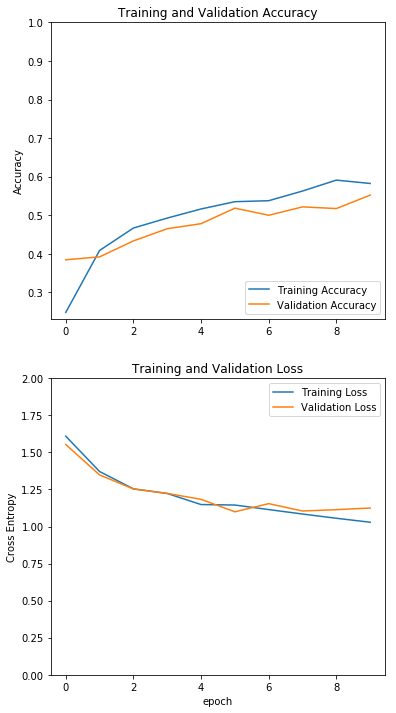

In [0]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(6, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**woops, it seems that the accuracy doesn't improve a lot although the model doesn't face overfitting. Let's try another model.**

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 93, 93, 32)        9248      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 22, 22, 64)      

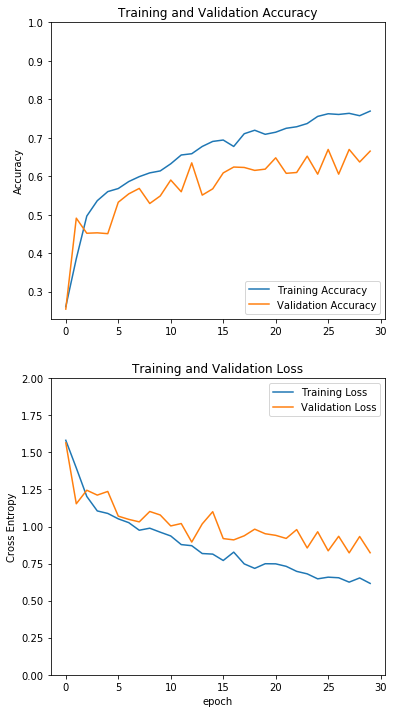

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
# model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(5, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# I realize we're using the test dataset (that's fine for this assignment)
history=model.fit(train_ds, validation_data=test_ds, epochs=30)



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(6, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Great! Thanks to a more complex model, we improve the performance a little bit(from 50% to more than 60%) although not super accurate.**

## 1c) Try to get your flowers model working in TensorFlow.js
In the final part of the assignment, you'll export the model you build to recognize landmarks on Columbia's campus, and get it working in the browser. It's easiest to start by exporting your flowers model, and getting it working with TensorFlow.js (the starter code is build around your flowers model, so you can learn the mechanics before trying something more complex).

### Save your model

In [0]:
model.save("/content/my_model.h5")

In [0]:
!ls -lha

total 21M
drwxr-xr-x 1 root root 4.0K Oct 13 19:50 .
drwxr-xr-x 1 root root 4.0K Oct 13 19:40 ..
drwxr-xr-x 1 root root 4.0K Oct  8 20:06 .config
-rw-r--r-- 1 root root  21M Oct 13 19:50 my_model.h5
drwxr-xr-x 1 root root 4.0K Aug 27 16:17 sample_data


### Download it to your local machine

In [0]:
from google.colab import files
files.download("/content/my_model.h5")

### Visit notebook #2 to convert it to TensorFlow.js format
Follow the instructions there to prepare a webpage to run your flowers model in the browser. Once you have that working, continue with the rest of this assignment.

## 1d) Transfer learning

In this part of the assignment, you'll use transfer learning to take advantage of a large pretrained model. It is not necesary to deploy this part in the browser.


References:
* https://www.tensorflow.org/beta/tutorials/images/transfer_learning

In [0]:
## TODO: your code here
# Choose a pretrained model, and import the application
# See https://keras.io/applications/ for a few choices
# When you import the model, you will want to remove the 
# final dense layer that performs classification (include_top=False)
# you will also want to import weights from ImageNet,
# and you will want to specify the input shape to match your images. 

 # fix me. base_model = tf.keras.applications...
IMG_SIZE=192
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [0]:
# A hack to show you the output shape of the model
for image_batch, label_batch in train_ds.take(1):
   pass
  
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [0]:
# do not update the pretrained weights during training
# (we won't use finetuning here)
base_model.trainable = False 

In [0]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [0]:
# build a new model reusing the pretrained base
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
86/86 [==============================] - 12s 143ms/step - loss: 0.8982 - accuracy: 0.6628 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
86/86 [==============================] - 7s 86ms/step - loss: 0.4795 - accuracy: 0.8339 - val_loss: 0.7478 - val_accuracy: 0.7320
Epoch 3/5
86/86 [==============================] - 8s 88ms/step - loss: 0.3859 - accuracy: 0.8710 - val_loss: 0.7283 - val_accuracy: 0.7473
Epoch 4/5
86/86 [==============================] - 7s 86ms/step - loss: 0.3388 - accuracy: 0.8877 - val_loss: 0.6614 - val_accuracy: 0.7767
Epoch 5/5
86/86 [==============================] - 8s 88ms/step - loss: 0.2959 - accuracy: 0.8964 - val_loss: 0.6763 - val_accuracy: 0.7691


## 2a) Recognize landmarks on Columbia's campus

In this part of the assignment, you will train a model to recognize landmarks (famous places, like the [Alma Mater sculpture](https://en.wikipedia.org/wiki/Alma_Mater_(New_York_sculpture), or Butler library) on Columbia’s campus. Instead of tf.data, you will gain experience with the higher level Keras utilties. You will also experiment with data augmentation to increase the effective size of your dataset.

Starter code is not provided for this part of the assignment. You should base your work off the following Keras notebook, which works identically in TF2 (the only thing you'll need to change is the imports, an example of correct imports is given below).

* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb

Here are steps you should complete.

1. Collect a dataset of at least three landmarks. Your dataset should include at least 50 images of each landmark in train, and 50 in validation (using more images is fine). Randomly shuffle your data to create these splits. You do not need to use a separate test set in this assignment.

 You will need to upload your dataset to Colab in order to train a model. To do so, you can either upload it using the file browser (slow and tedious, you'll need to repeat that if your runtime is reset), or (better) you can upload your dataset to Google Drive, then mount your drive as a filesystem in Colab (View -> Table of contents -> Code snippets -> search for "drive"). This will enable you to access the contents of your drive with commands like `!ls /gdrive`. As a another option, you could upload your dataset to a cloud provider or your Columbia account, then download it similarly to flowers at the top of this notebook.
 
1. Write a model to classify your data. Try to train a small model in terms of the number of parameters (you do not need to use transfer learning). 

1. Show predictions on several images.

1. Use data augmentation, see if this helps to improve accuracy.

1. Produce plots of accuracy / loss as a function of epochs. Determine the right place to stop training without overfitting.

When you have a reasonably accurate model, proceed to the next step. There are no guidelines for accuracy, try to build something you feel works well, given the small amount of data you have.

# data preparetion

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [0]:
! ls

'Colab Notebooks'    dataset   'MacBook Pro'
'Columbia Affairs'   dataset2   original


In [0]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/content/drive/My Drive/original'


In [0]:
import os, shutil

# The directory where we will
# store our smaller dataset
base_dir = '/content/drive/My Drive/dataset2'
# os.mkdir(base_dir)

In [0]:
# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
# os.mkdir(train_dir)


In [0]:
validation_dir = os.path.join(base_dir, 'validation')
# os.mkdir(validation_dir) 

In [0]:
# Directory with our training butler pictures
train_butler_dir = os.path.join(train_dir, 'butler')
os.mkdir(train_butler_dir)

# Directory with our training alma pictures
train_alma_dir = os.path.join(train_dir, 'alma')
os.mkdir(train_alma_dir)

# Directory with our training waston pictures
train_waston_dir = os.path.join(train_dir, 'waston')
os.mkdir(train_waston_dir)


In [0]:

# Directory with our validation butler pictures
validation_butler_dir = os.path.join(validation_dir, 'butler')
os.mkdir(validation_butler_dir)

# Directory with our validation alma pictures
validation_alma_dir = os.path.join(validation_dir, 'alma')
os.mkdir(validation_alma_dir)

# Directory with our validation waston pictures
validation_waston_dir = os.path.join(validation_dir, 'waston')
os.mkdir(validation_waston_dir)



In [0]:

# Copy first 50 butler images to train_butler_dir
fnames = ['butler.{}.JPG'.format(i) for i in range(1,100,2)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_butler_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 50 butler images to validation_cats_dir
fnames = ['butler.{}.JPG'.format(i) for i in range(2,101,2)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_butler_dir, fname)
    shutil.copyfile(src, dst)

In [0]:

fnames = ['alma.{}.JPG'.format(i) for i in range(1,100,2)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_alma_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['alma.{}.JPG'.format(i) for i in range(1,100,2)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_alma_dir, fname)
    shutil.copyfile(src, dst)

In [0]:

fnames = ['waston.{}.JPG'.format(i) for i in range(1,100,2)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_waston_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['waston.{}.JPG'.format(i) for i in range(1,100,2)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_waston_dir, fname)
    shutil.copyfile(src, dst)

# sanity check

In [0]:
print('total training butler images:', len(os.listdir(train_butler_dir)))
print('total training alma images:', len(os.listdir(train_alma_dir)))
print('total training waston images:', len(os.listdir(train_waston_dir)))

print('total validation butler images:', len(os.listdir(validation_butler_dir)))
print('total validation alma images:', len(os.listdir(validation_alma_dir)))
print('total validation waston images:', len(os.listdir(validation_waston_dir)))


total training butler images: 50
total training alma images: 50
total training waston images: 50
total validation butler images: 50
total validation alma images: 50
total validation waston images: 50


# Building our network

In [0]:

import keras
keras.__version__


Using TensorFlow backend.


'2.2.5'

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


In [0]:
img_width, img_height = 50, 50
nb_train_samples = 150
nb_validation_samples = 150
epochs = 10
batch_size = 20


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(3)) # 3 classes
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['accuracy'])

train_datagen = ImageDataGenerator(rescale=1./255)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical') 
#     class_mode='binary') 


validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical') 
#     class_mode='binary') 



Found 150 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [0]:

history=model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)


Epoch 1/10
7/7 [==============================] - 47s 7s/step - loss: 1.0811 - acc: 0.4429 - val_loss: 0.8765 - val_acc: 0.5786
Epoch 2/10
7/7 [==============================] - 53s 8s/step - loss: 0.8623 - acc: 0.6302 - val_loss: 0.7351 - val_acc: 0.9077
Epoch 3/10
7/7 [==============================] - 49s 7s/step - loss: 0.5888 - acc: 0.8712 - val_loss: 0.5358 - val_acc: 0.7769
Epoch 4/10
7/7 [==============================] - 48s 7s/step - loss: 0.4817 - acc: 0.8786 - val_loss: 0.4139 - val_acc: 0.9000
Epoch 5/10
7/7 [==============================] - 44s 6s/step - loss: 0.3415 - acc: 0.9279 - val_loss: 0.3711 - val_acc: 0.8385
Epoch 6/10
7/7 [==============================] - 44s 6s/step - loss: 0.1968 - acc: 0.9587 - val_loss: 0.1483 - val_acc: 0.9769
Epoch 7/10
7/7 [==============================] - 43s 6s/step - loss: 0.2041 - acc: 0.9505 - val_loss: 0.1444 - val_acc: 0.9769
Epoch 8/10
7/7 [==============================] - 43s 6s/step - loss: 0.1948 - acc: 0.9712 - val_loss: 0

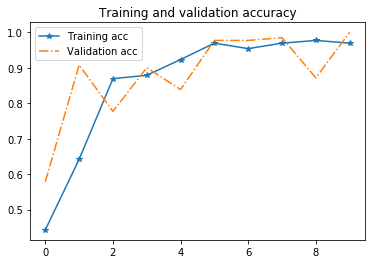

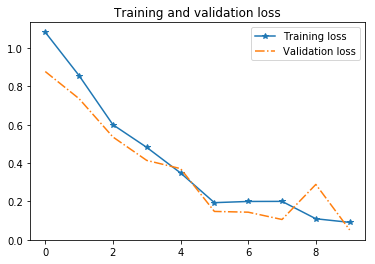

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']

val_loss = history.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, '-*', label='Training acc')
plt.plot(epochs, val_acc, '-.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, '-*', label='Training loss')
plt.plot(epochs, val_loss, '-.', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

 **Our training accuracy increases linearly over time, until it reaches nearly 100% while the validation accuracy flucuated around 90%. This happens when the dataset is customized by ourselves and many training images are similar to each other.**

**Because we only have relatively few training samples (150), overfitting is going to be our number one concern. A number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to use a new one, specific to computer vision, and used almost universally when processing images with deep learning models: data augmentation.**

In [0]:
model.save('columbia.h5')

# show several predictions 

In [0]:
loaded_model = tf.keras.models.load_model('columbia.h5')
loaded_model.layers[0].input_shape 

(None, 50, 50, 3)

In [0]:
# test_dir = os.path.join(base_dir, 'test')
# os.mkdir(test_dir)
# # Directory with our test butler pictures
# test_butler_dir = os.path.join(test_dir, 'butler')
# os.mkdir(test_butler_dir)

In [0]:
# test_waston_dir = os.path.join(test_dir, 'waston')
# os.mkdir(test_waston_dir)

In [0]:

# # Copy 101-110 butler images to test_butler_dir
# fnames = ['butler.{}.JPG'.format(i) for i in range(101,110)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(test_butler_dir, fname)
#     shutil.copyfile(src, dst)

In [0]:

# # Copy 101-110 butler images to test_butler_dir
# fnames = ['waston.{}.JPG'.format(i) for i in range(101,106)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(test_waston_dir, fname)
#     shutil.copyfile(src, dst)

In [0]:
map={0:'alma',1:'butler',2:"waston"}

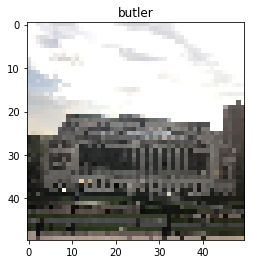

In [0]:
image_path="/content/drive/My Drive/dataset/test/butler/butler.101.JPG"
img = image.load_img(image_path, target_size=(50, 50))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
result=loaded_model.predict_classes(img)
plt.title(map[result[0]])
plt.show()

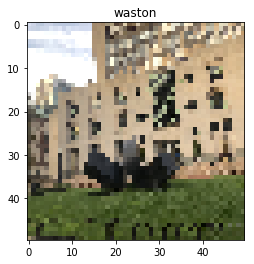

In [0]:
image_path="/content/drive/My Drive/dataset/test/waston/waston.101.JPG"
img = image.load_img(image_path, target_size=(50,50))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
result=loaded_model.predict_classes(img)
plt.title(map[result[0]])
plt.show()

#### correct prediction!

# data augmentation

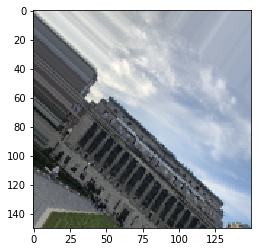

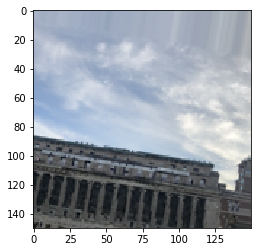

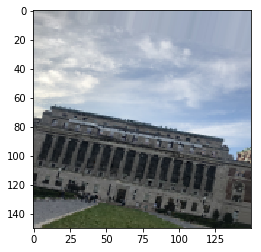

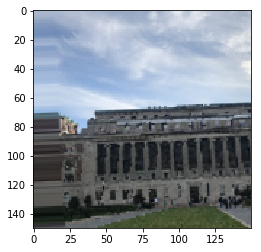

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_butler_dir, fname) for fname in os.listdir(train_butler_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (50, 50, 3)
x = image.img_to_array(img)

# Reshape it to (1, 50, 50, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

# Let's train our network using data augmentation and dropout:

In [0]:
img_width, img_height = 50, 50


# nb_train_samples = 150
# nb_validation_samples = 150
epochs = 10
batch_size = 20


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3)) # 3 classes
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical') 
#     class_mode='binary') 


validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical') 
#     class_mode='binary') 



Found 150 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [0]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=8
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



Epoch 1/10




30/30 [==============================] - 170s - loss: 0.9809 - acc: 0.5382 - val_loss: 0.5494 - val_acc: 0.6600
Epoch 2/10
30/30 [==============================] - 133s - loss: 0.7451 - acc: 0.6671 - val_loss: 0.3633 - val_acc: 0.9667
Epoch 3/10
30/30 [==============================] - 134s - loss: 0.5435 - acc: 0.7865 - val_loss: 0.1913 - val_acc: 1.0000
Epoch 4/10
30/30 [==============================] - 132s - loss: 0.4454 - acc: 0.8467 - val_loss: 0.1147 - val_acc: 0.9800
Epoch 5/10
30/30 [==============================] - 136s - loss: 0.3200 - acc: 0.8816 - val_loss: 0.0448 - val_acc: 1.0000
Epoch 6/10
30/30 [==============================] - 132s - loss: 0.2109 - acc: 0.9199 - val_loss: 0.0246 - val_acc: 1.0000
Epoch 7/10
30/30 [=========================

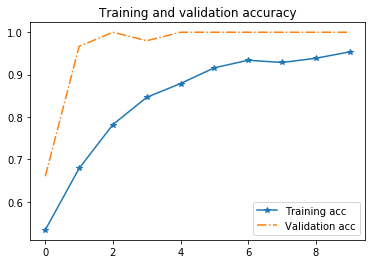

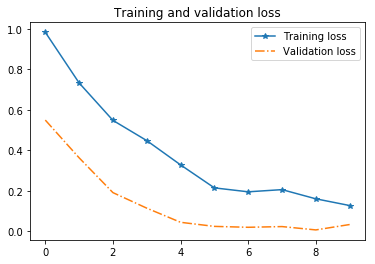

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']

val_loss = history.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, '-*', label='Training acc')
plt.plot(epochs, val_acc, '-.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, '-*', label='Training loss')
plt.plot(epochs, val_loss, '-.', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
model.save('columbia2.h5')

**Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation curves. One thing deserves attention here is the validation accuract is higher than training accuracy. Couple of reasons can explain that curve.1. The validation set are simple to predict. 2. we used dropout during training while there was no dropout applied druing validation process.**

## 2b) Donate your dataset (optional)
We will use the dataset collected by the class later in the semester.

Requirements:

* Please do not include any images with people in the foreground.
* Only include images you have taken yourself and that you are comfortable sharing publicly under a [CCO](https://creativecommons.org/share-your-work/public-domain/cc0/) license (TLDR, public domain).

Link to upload a zip is on CourseWorks. Your file should be in the same format as the flowers dataset (the directory names gives the label for each image).



## 3) Run your model in the browser
Save and download your model, and head to notebook two again. After you've finished creating a webpage, upload it to GitHub pages or your Columbia account, list the URL here, and submit your assignment. You may not need to make many changes to the starter code, but pay attention to the preprocessing, number of output classes, image size, etc.

**The personal page is on https://slayalphalu.github.io**

